In [1]:
import os
from math import inf
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
import pandas as pd


In [2]:
np.random.seed(0)

def is_dominated(v, V):
    for u in V:
        if np.all(u <= v) and np.any(u < v):
            return True
    return False


def nondominated_set(V):
    V = np.asarray(V)
    if V.size == 0:
        return np.empty((0, V.shape[1] if V.ndim>1 else 1))
    nd = []
    for i, v in enumerate(V):
        others = np.delete(V, i, axis=0)
        if not is_dominated(v, others):
            nd.append(v)
    return np.array(nd)



In [3]:

def F_obj(x):
    # Dwukryterialny przykład F: R^2 -> R^2
    x1, x2 = x
    f1 = (x1 - 0.3)**2 + 0.5*(x2 + 0.2)**2 + 0.3*x1*x2 + 0.1*(x1**3)
    f2 = (x1 + 0.4)**2 + 0.7*(x2 - 0.1)**2 + 0.2*np.sin(3*x1) + 0.05*(x2**3)
    return np.array([f1, f2])


def G_obj(x):
    # Trzykryterialny przykład G: R^3 -> R^3
    x1, x2, x3 = x
    g1 = (x1 - 0.2)**2 + 0.4*(x2 + 0.1)**2 + 0.2*(x3**2)
    g2 = (x1 + 0.3)**2 + 0.5*(x2 - 0.3)**2 + 0.3*np.sin(2*x3)
    g3 = 0.6*(x1**2) + 0.2*(x2**3) + (x3 + 0.2)**2 + 0.1*x1*x2
    return np.array([g1, g2, g3])



In [4]:

# Parametry dziedziny
bounds_2d = [(-1.0, 1.0), (-1.0, 1.0)]
bounds_3d = [(-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0)]


# Próbkowanie dziedziny
def sample_objectives(obj_fun, bounds, n_samples=3000):
    dim = len(bounds)
    lo = np.array([b[0] for b in bounds])
    hi = np.array([b[1] for b in bounds])
    X = np.random.uniform(lo, hi, size=(n_samples, dim))
    Y = np.array([obj_fun(x) for x in X])
    return X, Y



In [5]:

# Metody skalaryzacji

def scalarize_S1_weighted_sum(obj_fun, bounds, lambdas, n_restarts=5):
    # S1: liniowa suma wag.
    solutions = []
    lo = np.array([b[0] for b in bounds])
    hi = np.array([b[1] for b in bounds])
    dim = len(bounds)
    for lam in lambdas:
        w = np.array(lam, dtype=float)
        if w.sum() == 0:
            continue
        w = w / np.sum(w)
        def f(x):
            return float(np.dot(w, obj_fun(x)))
        best_res = None
        for attempt in range(n_restarts):
            x0 = np.random.uniform(lo, hi)
            res = minimize(f, x0=x0, bounds=bounds, method='SLSQP')
            if res.success:
                if best_res is None or res.fun < best_res.fun:
                    best_res = res
        if best_res is not None:
            solutions.append((best_res.x, obj_fun(best_res.x)))
    return solutions


def scalarize_S2_epsilon_constraints(obj_fun, bounds, main_index, epsilons, n_restarts=3):
    # S2: epsilon-ograniczenia. main_index: indeks celu minimalizowanego.
    solutions = []
    lo = np.array([b[0] for b in bounds])
    hi = np.array([b[1] for b in bounds])
    nobj = len(obj_fun(lo))
    for eps in epsilons:
        def f(x):
            return float(obj_fun(x)[main_index])
        cons = []
        if nobj == 2:
            other = 1 - main_index
            eps_val = float(eps)
            cons = ({'type': 'ineq', 'fun': (lambda x, other=other, eps_val=eps_val: eps_val - obj_fun(x)[other])},)
        else:
            # eps powinien byc iterowalnym z nobj-1 elementami
            eps_tuple = tuple(eps)
            others = [i for i in range(nobj) if i != main_index]
            for idx, iobj in enumerate(others):
                eps_i = float(eps_tuple[idx])
                cons.append({'type': 'ineq', 'fun': (lambda x, iobj=iobj, eps_i=eps_i: eps_i - obj_fun(x)[iobj])})
        best_res = None
        for attempt in range(n_restarts):
            x0 = np.random.uniform(lo, hi)
            try:
                res = minimize(f, x0=x0, bounds=bounds, constraints=cons, method='SLSQP')
            except Exception:
                res = None
            if res is not None and res.success:
                if best_res is None or res.fun < best_res.fun:
                    best_res = res
        if best_res is not None:
            solutions.append((best_res.x, obj_fun(best_res.x)))
    return solutions


def scalarize_S3_distance(obj_fun, bounds, ref_point, p=2, n_restarts=5):
    # S3: minimalizacja odległości
    lo = np.array([b[0] for b in bounds])
    hi = np.array([b[1] for b in bounds])
    def norm_diff(x):
        diff = obj_fun(x) - ref_point
        if p == np.inf or p == float('inf'):
            return float(np.max(np.abs(diff)))
        return float((np.sum(np.abs(diff)**p))**(1.0/p))
    best_res = None
    for attempt in range(n_restarts):
        x0 = np.random.uniform(lo, hi)
        res = minimize(lambda x: norm_diff(x), x0=x0, bounds=bounds, method='SLSQP')
        if res.success:
            if best_res is None or res.fun < best_res.fun:
                best_res = res
    sols = []
    if best_res is not None:
        sols.append((best_res.x, obj_fun(best_res.x)))
    return sols



In [6]:

# Eksperymenty

def run_bi_objective_experiment():
    print('--- DWUKRYTERIALNY (F) ---')
    X2, Y2 = sample_objectives(F_obj, bounds_2d, n_samples=3000)
    ideal2 = np.min(Y2, axis=0)
    nadir2 = np.max(Y2, axis=0)
    print('Est. ideal:', ideal2, 'nadir:', nadir2)

    # S1: siatka wag (normalizacja wag)
    n_weights = 40
    weights = []
    for k in range(n_weights+1):
        w1 = k / n_weights
        w2 = 1.0 - w1
        weights.append([w1, w2])
    sols_S1 = scalarize_S1_weighted_sum(F_obj, bounds_2d, weights)

    # S2: epsilon-ograniczenia
    eps_values_12 = np.linspace(np.min(Y2[:,1]), np.max(Y2[:,1]), 30)
    sols_S2 = scalarize_S2_epsilon_constraints(F_obj, bounds_2d, main_index=0, epsilons=eps_values_12)
    eps_values_21 = np.linspace(np.min(Y2[:,0]), np.max(Y2[:,0]), 30)
    sols_S2 += scalarize_S2_epsilon_constraints(F_obj, bounds_2d, main_index=1, epsilons=eps_values_21)

    # S3: minimalizacja odlegóości do punktu idealnego
    sols_S3 = []
    sols_S3 += scalarize_S3_distance(F_obj, bounds_2d, ideal2, p=2)
    sols_S3 += scalarize_S3_distance(F_obj, bounds_2d, ideal2, p=float('inf'))

    Pts_S1 = np.array([y for (x,y) in sols_S1]) if sols_S1 else np.empty((0,2))
    Pts_S2 = np.array([y for (x,y) in sols_S2]) if sols_S2 else np.empty((0,2))
    Pts_S3 = np.array([y for (x,y) in sols_S3]) if sols_S3 else np.empty((0,2))

    all_pts = np.vstack([p for p in (Pts_S1, Pts_S2, Pts_S3) if p.size>0]) if any(p.size>0 for p in (Pts_S1, Pts_S2, Pts_S3)) else np.empty((0,2))
    pareto = nondominated_set(all_pts) if all_pts.size>0 else np.empty((0,2))

    # Wizualizacja
    plt.figure(figsize=(8,6))
    plt.scatter(Y2[:,0], Y2[:,1], s=8, alpha=0.6, label='Sampling')
    if Pts_S1.size>0:
        plt.scatter(Pts_S1[:,0], Pts_S1[:,1], marker='x', label='S1 solutions')
    if Pts_S2.size>0:
        plt.scatter(Pts_S2[:,0], Pts_S2[:,1], marker='s', label='S2 solutions')
    if Pts_S3.size>0:
        plt.scatter(Pts_S3[:,0], Pts_S3[:,1], marker='^', label='S3 solutions')

    if pareto.size>0:
        pf = pareto[np.argsort(pareto[:,0])]
        try:
            tck, u = splprep([pf[:,0], pf[:,1]], s=1.0)
            u_fine = np.linspace(0,1,300)
            xs, ys = splev(u_fine, tck)
            plt.plot(xs, ys, linewidth=2, label='Pareto spline')
        except Exception:
            plt.plot(pf[:,0], pf[:,1], linewidth=2, label='Pareto (poly)')

    plt.xlabel('F1'); plt.ylabel('F2'); plt.title('Bi-objective: sampling & scalarization approximations')
    plt.legend(); plt.grid(True); plt.tight_layout()
    os.makedirs('output', exist_ok=True)
    plt.savefig('output/pareto_bi_plot.png', dpi=200)
    plt.show()

    df_bi = pd.DataFrame(pareto, columns=['F1','F2']) if pareto.size>0 else pd.DataFrame(columns=['F1','F2'])
    df_bi.to_csv('output/pareto_bi.csv', index=False)
    print('Zapisano output/pareto_bi.csv i output/pareto_bi_plot.png')

    return df_bi


def run_tri_objective_experiment():
    print('--- TRZYKRYTERIALNY ---')
    X3, Y3 = sample_objectives(G_obj, bounds_3d, n_samples=5000)
    ideal3 = np.min(Y3, axis=0)
    nadir3 = np.max(Y3, axis=0)
    print('Est. ideal:', ideal3, 'nadir:', nadir3)

    # S1: generowanie wag na prostym podziale sympleksu (siatka m)
    weights = []
    m = 12
    for i in range(m+1):
        for j in range(m+1-i):
            k = m - i - j
            w = np.array([i,j,k], dtype=float)
            if w.sum() == 0: continue
            weights.append(w / w.sum())
    sols_S1 = scalarize_S1_weighted_sum(G_obj, bounds_3d, weights)

    # S2: epsilon-ograniczenia: dla kazdego celu minimalizujemy go z ograniczeniami dla pozostałych
    sols_S2 = []
    nobj = 3
    eps_ranges = [np.linspace(np.min(Y3[:,i]), np.max(Y3[:,i]), 6) for i in range(nobj)]
    for main in range(nobj):
        others = [i for i in range(nobj) if i!=main]
        grid = np.array(np.meshgrid(eps_ranges[others[0]], eps_ranges[others[1]])).T.reshape(-1,2)
        eps_list = [tuple(g) for g in grid]
        sols_S2 += scalarize_S2_epsilon_constraints(G_obj, bounds_3d, main_index=main, epsilons=eps_list)

    # S3: minimalizacja odległości do punktu idealnego
    sols_S3 = scalarize_S3_distance(G_obj, bounds_3d, ideal3, p=2)

    Pts_S1 = np.array([y for (x,y) in sols_S1]) if sols_S1 else np.empty((0,3))
    Pts_S2 = np.array([y for (x,y) in sols_S2]) if sols_S2 else np.empty((0,3))
    Pts_S3 = np.array([y for (x,y) in sols_S3]) if sols_S3 else np.empty((0,3))

    all_pts = np.vstack([p for p in (Pts_S1, Pts_S2, Pts_S3) if p.size>0]) if any(p.size>0 for p in (Pts_S1, Pts_S2, Pts_S3)) else np.empty((0,3))
    pareto = nondominated_set(all_pts) if all_pts.size>0 else np.empty((0,3))

    # Wizualizacja
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(Y3[:,0], Y3[:,1], Y3[:,2], s=6, alpha=0.4)
    if Pts_S1.size>0:
        ax.scatter(Pts_S1[:,0], Pts_S1[:,1], Pts_S1[:,2], marker='x', label='S1')
    if Pts_S2.size>0:
        ax.scatter(Pts_S2[:,0], Pts_S2[:,1], Pts_S2[:,2], marker='s', label='S2')
    if Pts_S3.size>0:
        ax.scatter(Pts_S3[:,0], Pts_S3[:,1], Pts_S3[:,2], marker='^', label='S3')
    if pareto.size>0:
        ax.scatter(pareto[:,0], pareto[:,1], pareto[:,2], s=50, c='k', label='Pareto approx')
    ax.set_xlabel('G1'); ax.set_ylabel('G2'); ax.set_zlabel('G3')
    ax.set_title('Tri-objective: sampling & scalarization approximations')
    ax.legend(); plt.tight_layout()
    plt.savefig('output/pareto_tri_plot.png', dpi=200)
    plt.show()

    df_tri = pd.DataFrame(pareto, columns=['G1','G2','G3']) if pareto.size>0 else pd.DataFrame(columns=['G1','G2','G3'])
    df_tri.to_csv('output/pareto_tri.csv', index=False)
    print('Zapisano output/pareto_tri.csv i output/pareto_tri_plot.png')

    return df_tri


--- DWUKRYTERIALNY (F) ---
Est. ideal: [-0.01996697 -0.1916157 ] nadir: [2.15781577 2.62983841]


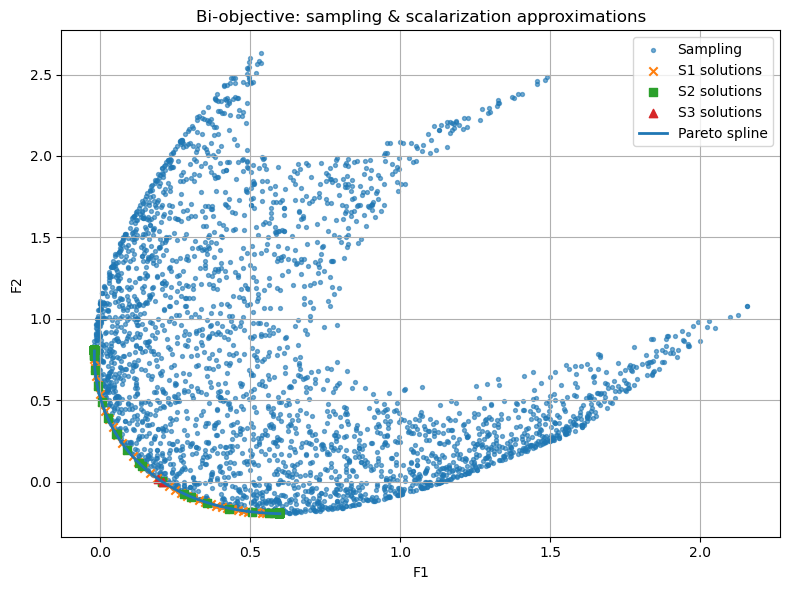

Zapisano output/pareto_bi.csv i output/pareto_bi_plot.png
--- TRZYKRYTERIALNY ---
Est. ideal: [ 0.00095076 -0.29759129 -0.18729622] nadir: [1.95258024 2.80454516 2.20746818]


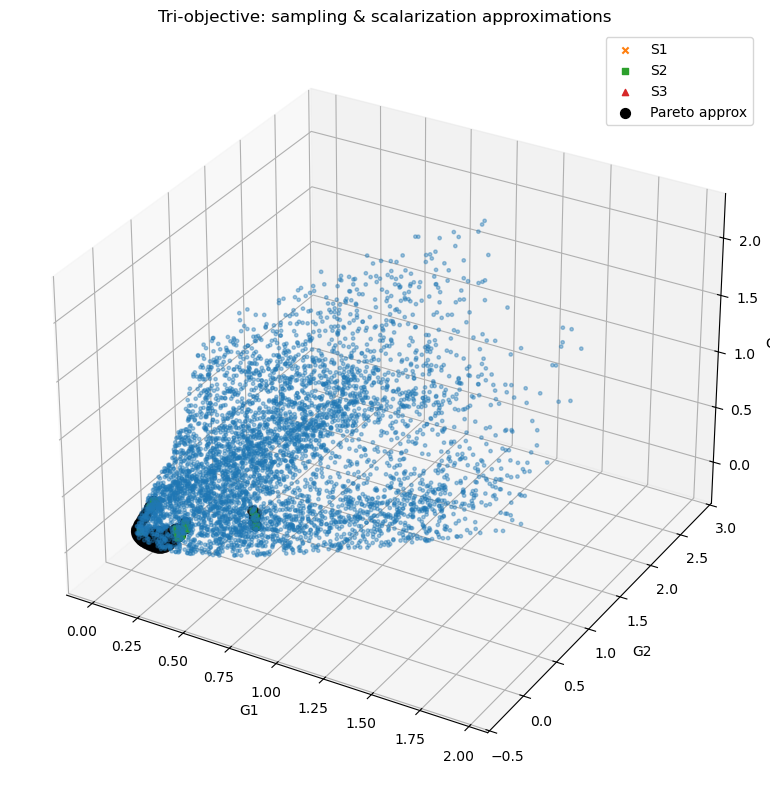

Zapisano output/pareto_tri.csv i output/pareto_tri_plot.png
Wszystkie pliki w katalogu output: ['pareto_bi.csv', 'pareto_bi_plot.png', 'pareto_tri.csv', 'pareto_tri_plot.png']


In [7]:
df_bi = run_bi_objective_experiment()
df_tri = run_tri_objective_experiment()
print('Wszystkie pliki w katalogu output:', os.listdir('output'))